# Per Capita

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Segoe UI'


# Manchester All accidents per ward per capita 

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


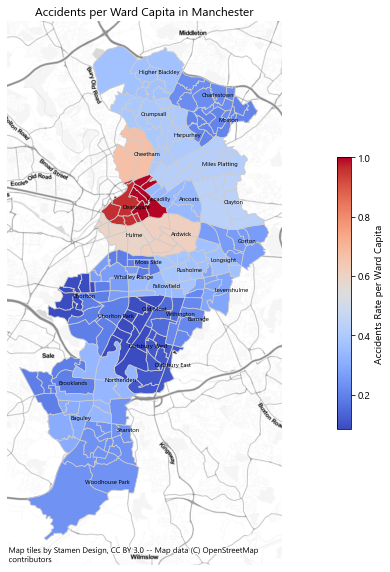

In [4]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')

# Filter data to show accidents in Manchester
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the manchester_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
manchester_wards_gdf = manchester_wards_gdf.assign(
    total_population=manchester_wards_gdf["Ward"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward
manchester_wards_gdf["accidents_per_capita"] = manchester_wards_gdf["accidents"] / manchester_wards_gdf["total_population"]




# Normalize accidents_per_capita to the range [0, 1]
manchester_wards_gdf["normalized_accidents_per_capita"] = manchester_wards_gdf["accidents_per_capita"] / manchester_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)






# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis("off")
ax.set_title("Accidents per Ward Capita in Manchester")
plt.savefig("manchester_wards_accidents_per_capita.png", dpi=600, bbox_inches="tight")
plt.show()




In [5]:
top_5_wards = manchester_wards_gdf.sort_values(by='accidents_per_capita', ascending=False).head(30)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)



['Piccadilly Ward' 'Deansgate Ward' 'Cheetham Ward' 'Ardwick Ward'
 'Hulme Ward']


In [6]:
# sum_observation = pop_df[pop_df['Electoral wards and divisions'] == 'Higher Blackley']['Observation'].sum()

# print(sum_observation)


# Manchester Cyclist¶

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


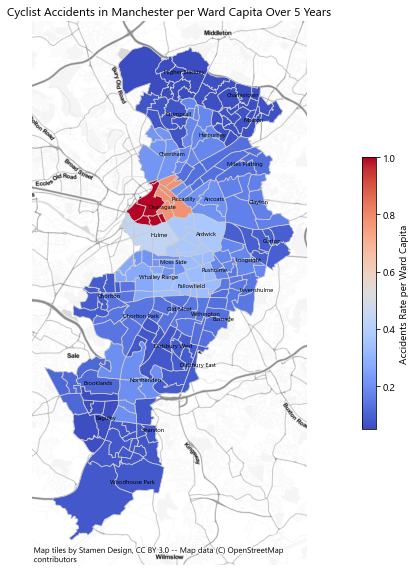

In [7]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')

# Filter data to show accidents in Manchester involving cyclists
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)") & (df["casualty_type"] == "Cyclist")]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the manchester_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
manchester_wards_gdf = manchester_wards_gdf.assign(
    total_population=manchester_wards_gdf["Ward"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward
manchester_wards_gdf["accidents_per_capita"] = manchester_wards_gdf["accidents"] / manchester_wards_gdf["total_population"]




# Normalize accidents_per_capita to the range [0, 1]
manchester_wards_gdf["normalized_accidents_per_capita"] = manchester_wards_gdf["accidents_per_capita"] / manchester_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)






# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Cyclist Accidents in Manchester per Ward Capita Over 5 Years')
plt.savefig('cyclist_manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()




In [8]:
top_5_wards = manchester_wards_gdf.sort_values(by='accidents_per_capita', ascending=False).head(30)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)





['Deansgate Ward' 'Piccadilly Ward' 'Hulme Ward' 'Ardwick Ward'
 'Fallowfield Ward']


# Pedestrian Manchester

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


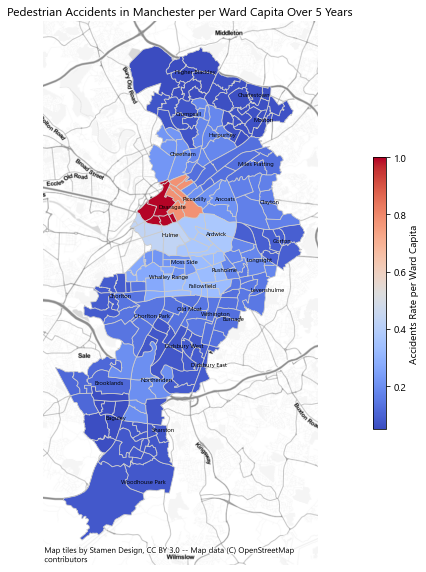

In [9]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')

# Filter data to show accidents in Manchester involving cyclists
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)") & (df["casualty_type"] == "Cyclist")]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the manchester_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
manchester_wards_gdf = manchester_wards_gdf.assign(
    total_population=manchester_wards_gdf["Ward"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward
manchester_wards_gdf["accidents_per_capita"] = manchester_wards_gdf["accidents"] / manchester_wards_gdf["total_population"]




# Normalize accidents_per_capita to the range [0, 1]
manchester_wards_gdf["normalized_accidents_per_capita"] = manchester_wards_gdf["accidents_per_capita"] / manchester_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)






# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Pedestrian Accidents in Manchester per Ward Capita Over 5 Years')
plt.savefig('Pedestrian_manchester_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()




In [10]:
top_5_wards = manchester_wards_gdf.sort_values(by='accidents_per_capita', ascending=False).head(30)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)





['Deansgate Ward' 'Piccadilly Ward' 'Hulme Ward' 'Ardwick Ward'
 'Fallowfield Ward']


# Childern Under 16 Manchester

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


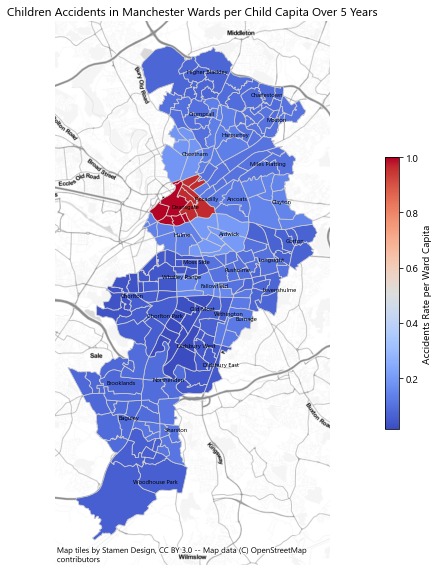

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Manchester" with "Manchester District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Manchester', 'Manchester District (B)')


# Filter data to show accidents in Manchester involving Children
manchester_data = df[(df["local_authority_district"] == "Manchester District (B)") & (df["age_of_casualty"] < 16)]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(manchester_data["longitude"], manchester_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(manchester_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Manchester wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Manchester wards
manchester_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Manchester District (B)"]

# # Convert the CRS of the accidents GeoDataFrame to match the CRS of the Manchester wards GeoDataFrame
# accidents_gdf = accidents_gdf.to_crs(manchester_wards_gdf.crs)

# Convert the CRS of the accidents GeoDataFrame and Manchester wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
manchester_wards_gdf = manchester_wards_gdf.to_crs("EPSG:3857")


# Perform a spatial join between the accidents GeoDataFrame and the Manchester wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, manchester_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Manchester wards GeoDataFrame
manchester_wards_gdf["accidents"] = manchester_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Filter the population data to include only children aged 15 years and under
pop_df_children = pop_df[pop_df["Age (6 categories)"] == "Aged 15 years and under"]

# Calculate the total population of children per ward
total_children_pop_per_ward = pop_df_children.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_children_pop_per_ward.columns = ["Ward_Name", "Total Children Population"]

# Extract the first word from the ward names
total_children_pop_per_ward["First_Word"] = total_children_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the manchester_wards_gdf with the total_children_pop_per_ward DataFrame by matching the ward names
manchester_wards_gdf = manchester_wards_gdf.assign(
    total_children_population=manchester_wards_gdf["Ward"].apply(
        lambda x: total_children_pop_per_ward.loc[total_children_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Children Population"].sum()
    )
)

# Calculate accidents per child capita for each ward
manchester_wards_gdf["accidents_per_child_capita"] = manchester_wards_gdf["accidents"] / manchester_wards_gdf["total_children_population"]







# Normalize accidents_per_capita to the range [0, 1]
manchester_wards_gdf["normalized_accidents_per_capita"] = manchester_wards_gdf["accidents_per_child_capita"] / manchester_wards_gdf["accidents_per_child_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
manchester_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)





# Calculate unique ward centroids
unique_ward_centroids = manchester_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Manchester Wards per Child Capita Over 5 Years')
plt.savefig('Children_manchester_wards_accidents_per_child_capita.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()






In [12]:
top_5_wards = manchester_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(30)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)



['Deansgate Ward' 'Piccadilly Ward' 'Ardwick Ward' 'Cheetham Ward'
 'Fallowfield Ward']


# Sheffield All accidents per ward capita 

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


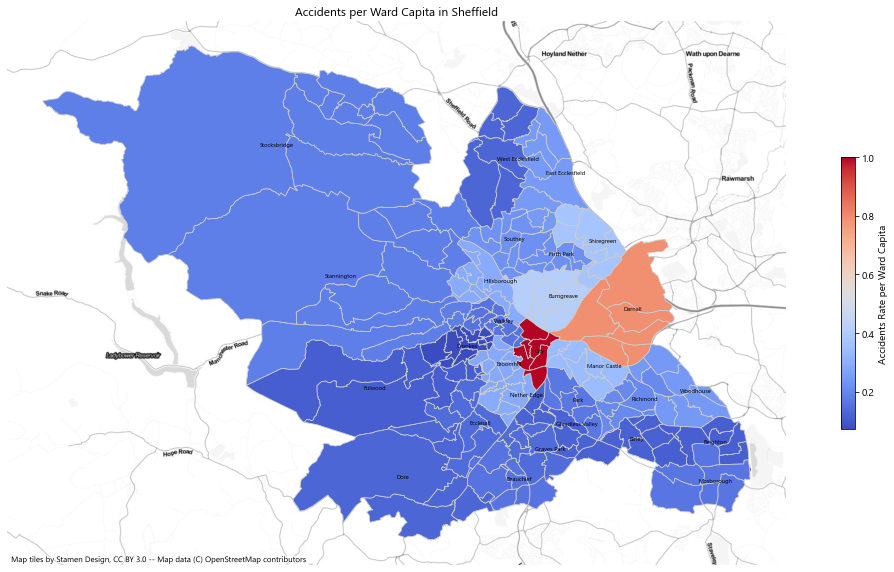

In [13]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')


# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Filter data to show accidents in Sheffield involving cyclists
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)")]



# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("sheff.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the sheffield_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
sheffield_wards_gdf = sheffield_wards_gdf.assign(
    total_population=sheffield_wards_gdf["Ward"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward
sheffield_wards_gdf["accidents_per_capita"] = sheffield_wards_gdf["accidents"] / sheffield_wards_gdf["total_population"]



# Normalize accidents_per_capita to the range [0, 1]
sheffield_wards_gdf["normalized_accidents_per_capita"] = sheffield_wards_gdf["accidents_per_capita"] / sheffield_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)








# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis("off")
ax.set_title("Accidents per Ward Capita in Sheffield")
plt.savefig("sheffield_wards_accidents_per_capita.png", dpi=600, bbox_inches="tight")
plt.show()



In [14]:
top_5_wards = sheffield_wards_gdf.sort_values(by='accidents_per_capita', ascending=False).head(30)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)





['City Ward' 'Darnall Ward' 'Burngreave Ward'
 'Shiregreen & Brightside Ward' 'Manor Castle Ward']


# Sheffield Cyclist

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


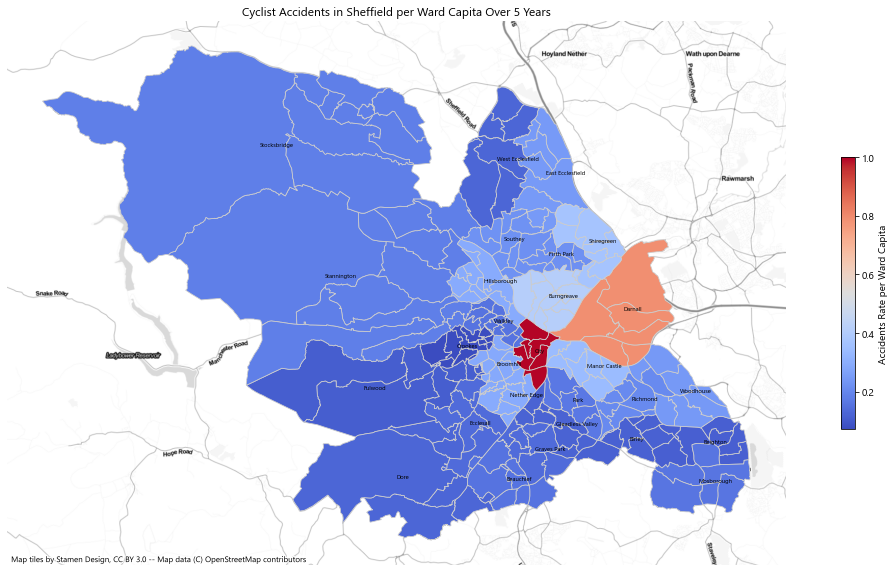

In [15]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')


# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')




# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("sheff.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the sheffield_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
sheffield_wards_gdf = sheffield_wards_gdf.assign(
    total_population=sheffield_wards_gdf["Ward"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward
sheffield_wards_gdf["accidents_per_capita"] = sheffield_wards_gdf["accidents"] / sheffield_wards_gdf["total_population"]



# Normalize accidents_per_capita to the range [0, 1]
sheffield_wards_gdf["normalized_accidents_per_capita"] = sheffield_wards_gdf["accidents_per_capita"] / sheffield_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)








# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Cyclist Accidents in Sheffield per Ward Capita Over 5 Years')
plt.savefig('cyclist_sheffield_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()




In [16]:
top_5_wards = sheffield_wards_gdf.sort_values(by='accidents_per_capita', ascending=False).head(30)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)






['City Ward' 'Darnall Ward' 'Burngreave Ward'
 'Shiregreen & Brightside Ward' 'Manor Castle Ward']


# Pedestrian Sheffield

C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


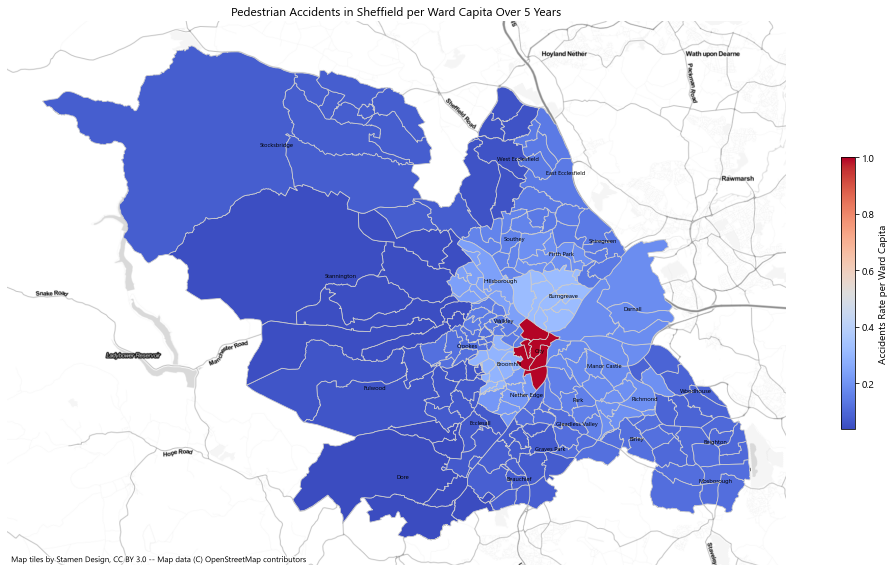

In [17]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')


# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')

# Filter data to show accidents in Sheffield involving Pedestrian
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)") & (df["casualty_type"] == "Pedestrian")]




# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Sheffield wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("sheff.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the sheffield_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
sheffield_wards_gdf = sheffield_wards_gdf.assign(
    total_population=sheffield_wards_gdf["Ward"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward
sheffield_wards_gdf["accidents_per_capita"] = sheffield_wards_gdf["accidents"] / sheffield_wards_gdf["total_population"]



# Normalize accidents_per_capita to the range [0, 1]
sheffield_wards_gdf["normalized_accidents_per_capita"] = sheffield_wards_gdf["accidents_per_capita"] / sheffield_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)








# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Pedestrian Accidents in Sheffield per Ward Capita Over 5 Years')
plt.savefig('Pedestrian_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()




In [18]:
top_5_wards = sheffield_wards_gdf.sort_values(by='accidents_per_capita', ascending=False).head(35)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)






['City Ward' 'Burngreave Ward' 'Broomhill & Sharrow Vale Ward'
 'Hillsborough Ward']


C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\DELL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


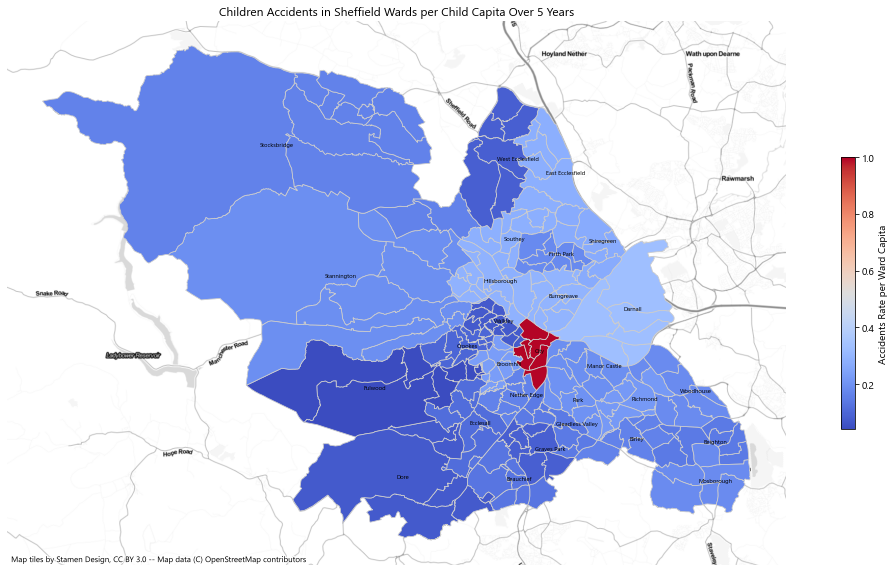

In [19]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Replace "Sheffield" with "Sheffield District (B)" in the local_authority_district column
df['local_authority_district'] = df['local_authority_district'].replace('Sheffield', 'Sheffield District (B)')


# Filter data to show accidents in Sheffield involving children
sheffield_data = df[(df["local_authority_district"] == "Sheffield District (B)") & (df["age_of_casualty"] < 16)]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(sheffield_data["longitude"], sheffield_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(sheffield_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the wards shapefile
wards_shapefile = "polling_districts_England_region.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Sheffield wards
sheffield_wards_gdf = wards_gdf[wards_gdf["Distric_Bo"] == "Sheffield District (B)"]

# Convert the CRS of the accidents GeoDataFrame and Sheffield wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
sheffield_wards_gdf = sheffield_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Sheffield wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, sheffield_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("Ward")["Ward"].count()

# Add the number of accidents to the Sheffield wards GeoDataFrame
sheffield_wards_gdf["accidents"] = sheffield_wards_gdf["Ward"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Filter the population data to include only children aged 15 years and under
pop_df_children = pop_df[pop_df["Age (6 categories)"] == "Aged 15 years and under"]

# Calculate the total population of children per ward
total_children_pop_per_ward = pop_df_children.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_children_pop_per_ward.columns = ["Ward_Name", "Total Children Population"]
# Merge the sheffield_wards_gdf with the total_children_pop_per_ward DataFrame by matching the ward names
sheffield_wards_gdf = sheffield_wards_gdf.assign(
    total_children_population=sheffield_wards_gdf["Ward"].apply(
        lambda x: total_children_pop_per_ward.loc[total_children_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Children Population"].sum()
    )
)

# Calculate accidents per child capita for each ward
sheffield_wards_gdf["accidents_per_child_capita"] = sheffield_wards_gdf["accidents"] / sheffield_wards_gdf["total_children_population"]

# Normalize accidents_per_child_capita to the range [0, 1]
sheffield_wards_gdf["normalized_accidents_per_child_capita"] = sheffield_wards_gdf["accidents_per_child_capita"] / sheffield_wards_gdf["accidents_per_child_capita"].max()

# Plot the map with normalized accidents per child capita
fig, ax = plt.subplots(1, figsize=(20, 10))
sheffield_wards_gdf.plot(column="normalized_accidents_per_child_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents Rate per Ward Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = sheffield_wards_gdf.dissolve(by="Ward", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["Ward"].replace("Ward", "").strip()
    ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Sheffield Wards per Child Capita Over 5 Years', fontname='Segoe UI')
plt.savefig('Children_sheffield_wards_accidents_per_child_capita.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


In [20]:
top_5_wards = sheffield_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(35)
unique_top_wards = top_5_wards['Ward'].unique()
print(unique_top_wards)







['City Ward' 'Darnall Ward' 'Burngreave Ward' 'Hillsborough Ward'
 'Southey Ward']


In [21]:
Segoe UI 

SyntaxError: invalid syntax (<ipython-input-21-6165a9573df5>, line 1)

In [ ]:
import matplotlib
print(matplotlib.matplotlib_fname())
